<a href="https://colab.research.google.com/github/rahul13ramesh/cis520-dataset/blob/master/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-520 Project -[What's cooking](https://www.kaggle.com/c/whats-cooking-kernels-only)

* This notebook looks at the Kaggle contest *What's cooking*. We tackle a supervised and unsupervised learning problem using this dataset
* The inputs are a collection of words and hence a key aspect of this problem is to convert the collection of words into a finite dimensional feature

In [22]:
!pip install pywaffle
!git clone https://github.com/amueller/word_cloud.git
!cd word_cloud && pip install .

fatal: destination path 'word_cloud' already exists and is not an empty directory.
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post1+g8217e20-cp36-cp36m-linux_x86_64.whl size=335569 sha256=23e0a561c1d8751c153c87603b047e69f1bef13ea2308fef784e6c003082b6b8
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfg8ix7r/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.6.0.post1+g8217e20
    Uninstalling wordcloud-1.6.0.post1+g8217e20:
      Successfully uninstalled wordcloud-1.6.0.post1+g8217e20


In [0]:
import numpy as np
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import json
import unicodedata
import re
import seaborn as sns
from gensim.models import word2vec
from gensim.models import KeyedVectors
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pywaffle import Waffle

In [24]:
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
!wget https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json

--2019-12-08 05:43:19--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/test.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2844086 (2.7M) [text/plain]
Saving to: ‘test.json.2’

test.json.2         100%[===================>]   2.71M  --.-KB/s    in 0.05s   

2019-12-08 05:43:19 (49.4 MB/s) - ‘test.json.2’ saved [2844086/2844086]

--2019-12-08 05:43:20--  https://raw.githubusercontent.com/rahul13ramesh/cis520-dataset/master/train.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415067 (12M) [text/plain]
Sav

# Loading dataset
We load the dataset and display a single entry from this dataset

In [0]:
with open("test.json", "r") as f:
    test_data = json.load(f)
with open("train.json", "r") as f:
    train_data = json.load(f)
train_data_df = pd.DataFrame(train_data)
test_data_df = pd.DataFrame(test_data)

Example from dataset

In [26]:
train_data[0]

{'cuisine': 'greek',
 'id': 10259,
 'ingredients': ['romaine lettuce',
  'black olives',
  'grape tomatoes',
  'garlic',
  'pepper',
  'purple onion',
  'seasoning',
  'garbanzo beans',
  'feta cheese crumbles']}

In [0]:
def create_train_test_data(train_data_df, test_data_df):
  """
  Splits the original training and test data
  """
  train_recepies = [] 
  train_targets = []
  for ig_item in train_data_df['ingredients']:
      train_recepies.append(ig_item)
  for cuisine_item in train_data_df['cuisine']:
      train_targets.append(cuisine_item)

  # create test data only, no targets
  test_recepies = []
  for ig_item in test_data_df['ingredients']:
      test_recepies.append(ig_item)
  return train_recepies, train_targets, test_recepies

In [28]:
train_features, train_targets, test_features = create_train_test_data(train_data_df, test_data_df)
print(train_targets[0:5])

['greek', 'southern_us', 'filipino', 'indian', 'indian']


#### Remove small receipies, special characters, quantity classifiers (inch, oz etc.)

This is the key-preprocessing function. The data is processed to contain only lower case alphabets and spaces. Additional features are added based on number of ingredients/characters/occurrence of special characters etc.


In [29]:
def process_features(features, targets, mode="train"):
    processed_recipe = []
    processed_cuisine = []
    count_len = 0

    for idx, recipe in enumerate(features):
        processed_ingredient = []

        # Convert to lower case
        if mode=='train':
            cuisine_lower = targets[idx].lower()

        cur_features = {}
        ingredient_all = ' '.join(recipe)

        # f1) Add feature for number of ingredients
        if len(recipe) <= 2:
            count_len += 1
            continue
        cur_features["num_ingredients"] = len(recipe)

        # f2) Change accented characters to ascii characters
        accented_char_set= ["â", "ç", "è", "é", "í", "î", "ú", "’"]
        cur_features["accented"] = 0
        if 1 in [c in ingredient_all for c in accented_char_set]:
            cur_features["accented"] = 1

        # f3) Add feature for measurement units
        measurement_words = ["pound", "kg", "lb", "oz", "ounc", "inch"]
        cur_features["measurement"] = 0
        if np.any([w in ingredient_all for w in measurement_words]):
            cur_features["measurement"] = 1

        # f4) Symbols
        cur_features["symbol"] = 0
        if ("™" in ingredient_all) or ("®" in ingredient_all) or ("!" in ingredient_all):
            cur_features["symbol"] = 1

        # f5) Feature for numbers
        cur_features["number"] = 0
        if any(char.isdigit() for char in ingredient_all):
            cur_features["number"] = 1
            
        # f6) Feature for percentage
        cur_features["percentage"] = 0
        if "%" in ingredient_all:
            cur_features["percentage"] = 1

        # p1) Convert to lower case
        ingredient_all = ingredient_all.lower()
        # p2) Change accented characters to ascii characters
        ingredient_all = unicodedata.normalize('NFD', ingredient_all).encode('ascii', 'ignore')
        ingredient_all = ingredient_all.decode('ascii')
        # p3) Remove measurement units
        ingredient_all = re.sub((r'\b(pound|kg|lb|oz|ounc|inch)\b'), ' ', ingredient_all) 
        # p4) Remove symbol
        ingredient_all = ingredient_all.replace("!", " ")
        ingredient_all = ingredient_all.replace("™", " ")
        ingredient_all = ingredient_all.replace("®", " ")
        # p5) Remove brackets
        ingredient_all = ingredient_all.replace("(", " ")
        ingredient_all = ingredient_all.replace(")", " ")
        # p6) Remove hyphens
        ingredient_all = ingredient_all.replace("-", " ")
        # p7) Remove numbers
        ingredient_all = re.sub("\d", " ", ingredient_all)
        # p8) Remove percentages and / (occur with numbers)
        ingredient_all = ingredient_all.replace("/", " ")
        ingredient_all = ingredient_all.replace("%", " ")

        # p9) Remove some more characters
        ingredient_all = ingredient_all.replace(".", " ")
        ingredient_all = ingredient_all.replace("€", " ")
        ingredient_all = ingredient_all.replace(",", " ")

        # p10) Handle apostrophe
        ingredient_all = ingredient_all.replace("’", "'")
        ingredient_all = ingredient_all.replace("'", "")

        # p11) Replace & with and
        ingredient_all = ingredient_all.replace("&", "and")

        ings = ' '.join(ingredient_all.split())
        cur_features["num_words"] = len(ingredient_all.split())

        processed_recipe.append((
                cur_features["num_words"], cur_features["num_ingredients"],
                cur_features["accented"], cur_features["measurement"],
                cur_features["symbol"], cur_features["number"],
                cur_features["percentage"], ings
            ))
        if mode=='train':
            processed_cuisine.append(cuisine_lower)
    
    print('Removed {} small recipe from input data'.format(count_len))
    if mode=='train':
        return processed_recipe, processed_cuisine
    else:
        return processed_recipe

processed_train_features, processed_train_target = process_features(train_features, train_targets, mode='train')
processed_test_features = process_features(test_features, train_targets,  mode='test') # just passing the targets, not using it while preprocessing test data


print(len(processed_train_target))
print(len(processed_train_features))

Removed 215 small recipe from input data
Removed 56 small recipe from input data
39559
39559


In [30]:
train_data = pd.DataFrame(processed_train_features)
test_data = pd.DataFrame(processed_test_features)

train_data.columns = ["num_words", "num_ingredients", "accented", "measurement", "symbol", "number", "percentage", "text"]
print(train_data.shape)

(39559, 8)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def generate_bag_of_words(train_bin_vec, test_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 2), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.001) 
    binarizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = binarizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = binarizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, binarizer

def generate_tf_idf(train_bin_vec, test_bin_vec, bin=False, ngrammax=2,
                    use_idf=True, smooth_idf=True, sublinear_tf=False,
                    mindf=0.001):
    vectorizer = TfidfVectorizer(input="content", preprocessor=None, tokenizer=None, 
                                 analyzer="word", ngram_range=(1, ngrammax), min_df=mindf,
                                 binary=bin, norm="l2", use_idf=use_idf, smooth_idf=smooth_idf,
                                 sublinear_tf=sublinear_tf)
    vectorizer.fit([str(i[-1]) for i in train_bin_vec])
    binary_vector_tr = vectorizer.transform([str(i[-1]) for i in train_bin_vec])
    binary_vector_te = vectorizer.transform([str(i[-1]) for i in test_bin_vec])
    return binary_vector_tr, binary_vector_te, vectorizer


In [0]:
def merge_representation(train_features, vectorized_text):
    merged_dat = []
    for i in range(len(train_features)):
        merged_dat.append(np.concatenate((np.array(train_features[i][:-1]), vectorized_text[i])))
    return np.array(merged_dat)

train_rep, test_rep, binarizer = generate_tf_idf(processed_train_features, processed_test_features,
                                                 bin=False, ngrammax=1, use_idf=True, smooth_idf=True,
                                                 sublinear_tf=False, mindf=0.0001)


# train_rep = merge_representation(processed_train_features, train_rep.toarray())

In [33]:
print(train_rep[0].shape)

(1, 1983)


# Unsupervised learning

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [35]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(train_rep)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

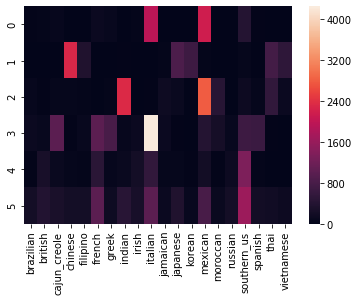

In [36]:
lab = kmeans.labels_
lb_en = LabelEncoder()
train_encoded = lb_en.fit_transform(processed_train_target)

kmean_map = np.zeros((6, 20))
for i in range(len(lab)):
    kmean_map[lab[i], train_encoded[i]] += 1

decoded_lb = lb_en.inverse_transform([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
index = list(decoded_lb)

kmean_map = pd.DataFrame(kmean_map)
kmean_map.columns =index
sns.heatmap(kmean_map)

In [0]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

      Component 1 Component 2         label
0       0.0137753   0.0185314  cajun_creole
1       -0.208435   -0.067693         greek
2       -0.107464    0.179499    vietnamese
3        0.463062 -0.00446232       italian
4       0.0083986   -0.216587         greek
...           ...         ...           ...
39554   0.0894365    0.118885    vietnamese
39555   -0.181259  -0.0111488   southern_us
39556    0.321125  0.00963139      jamaican
39557  -0.0750988   -0.176406       italian
39558  -0.0288914  -0.0173537       italian

[39559 rows x 3 columns]


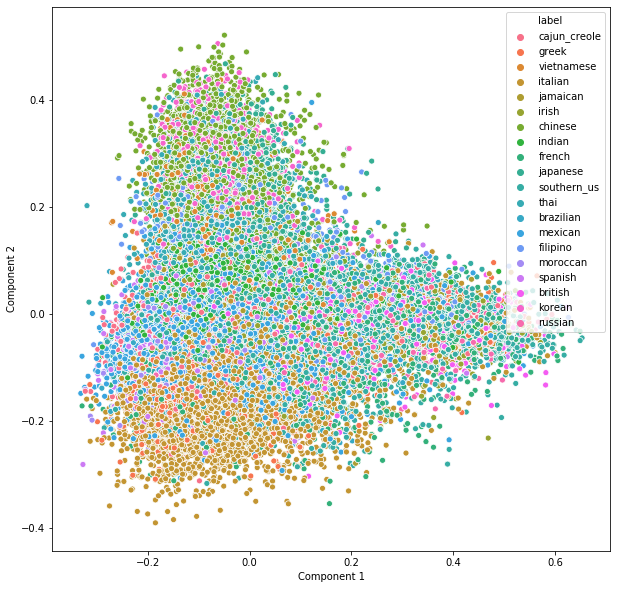

In [40]:
two_comp = np.array(pca.fit_transform(train_rep.toarray()))
ind = list(range(len(two_comp)))
np.random.shuffle(ind)
subsetlabel = [processed_train_target[i] for i in ind]
dat = pd.DataFrame([two_comp[ind, 0], two_comp[ind, 1], subsetlabel]).T
dat.columns = ["Component 1", "Component 2", "label"]
print(dat)
plt.figure(figsize=(10,10))
sns.scatterplot(x="Component 1", y="Component 2", hue="label", data=dat)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


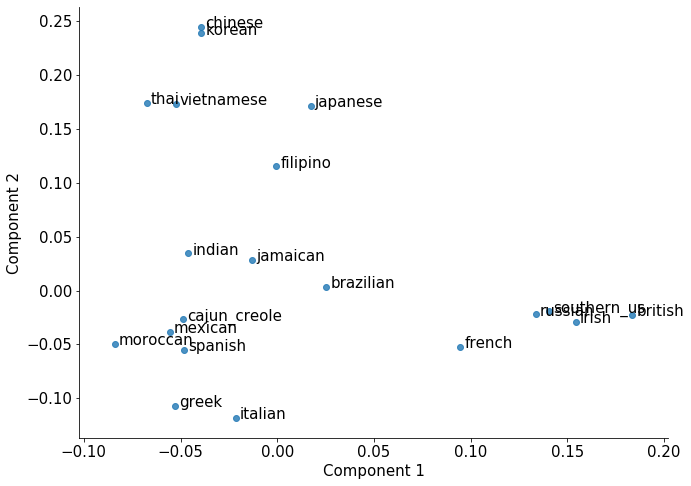

In [94]:
dat["Component 1"] = pd.to_numeric(dat["Component 1"])
dat["Component 2"] = pd.to_numeric(dat["Component 2"])
dat2 = dat.groupby("label").mean()
dat2["label"] = list(dat2.index)

ax = sns.lmplot('Component 1', 'Component 2', # Vertical axis
                data=dat2, # Data source
                fit_reg=False, # Don't fix a regression line
                size=7, aspect=1.4 ) # size and dimension

plt.rcParams.update({'font.size': 15})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.002, point['y'] - 0.001, str(point['val']))

label_point(dat2["Component 1"], dat2["Component 2"], dat2["label"], plt.gca())


In [0]:
two_comp = np.array(tsne.fit_transform(train_rep))
ind = list(range(len(two_comp)))
np.random.shuffle(ind)
subsetlabel = [processed_train_target[i] for i in ind]
dat = pd.DataFrame([two_comp[ind, 0], two_comp[ind, 1], subsetlabel]).T
dat.columns = ["Component 1", "Component 2", "label"]
print(dat)
sns.scatterplot(x="Component 1", y="Component 2", hue="label", data=dat)

In [0]:
dat["Component 1"] = pd.to_numeric(dat["Component 1"])
dat["Component 2"] = pd.to_numeric(dat["Component 2"])
dat2 = dat.groupby("label").mean()
dat2["label"] = list(dat2.index)

ax = sns.lmplot('Component 1', 'Component 2', # Vertical axis
                data=dat2, # Data source
                fit_reg=False, # Don't fix a regression line
                size=7, aspect=1.4 ) # size and dimension

plt.rcParams.update({'font.size': 15})
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.002, point['y'] - 0.001, str(point['val']))

label_point(dat2["Component 1"], dat2["Component 2"], dat2["label"], plt.gca())

In [92]:
def generate_counts(train_bin_vec):
    binarizer = CountVectorizer(analyzer = "word",  ngram_range = (1, 1), 
                                binary = False, tokenizer = None, preprocessor = None, 
                                stop_words = None,  min_df=0.003, max_df=1.0) 
    binary_vec = binarizer.fit_transform([str(i[-1]) for i in train_bin_vec])
    return binary_vec, binarizer

def print_topics(model, count_vectorizer, n_top_words=10):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

lda =  LatentDirichletAllocation(n_components=5)
count_data, binarizer = generate_counts(processed_train_features)
lda.fit(count_data)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [93]:
print_topics(lda, binarizer, 30)


Topic #0:
sugar sauce fresh juice lime ginger brown water rice soy oil coconut fish vinegar lemon milk orange light garlic salt sesame red leaves paste cilantro dark seeds white peanuts mint

Topic #1:
flour butter salt sugar all purpose eggs milk large baking cream powder water unsalted egg vanilla ground extract cheese oil white corn yolks whole soda heavy buttermilk vegetable cinnamon whites

Topic #2:
ground pepper salt garlic oil cheese onions tomatoes fresh olive red dried black powder cumin leaves parmesan cloves tomato basil coriander green grated water ginger paste onion oregano chopped chili

Topic #3:
fresh pepper salt oil olive garlic ground chopped juice black onion cloves lemon tomatoes chicken white parsley extra cilantro wine virgin red lime cheese vinegar broth purple leaves dry kosher

Topic #4:
pepper sauce chicken oil onions garlic green salt corn ground rice black soy cheese red water sesame bell boneless powder vegetable cream shredded chili beans broth skinless 